# **CNN Cancer Detection**

---
---
# **1. Brief description of the problem and data**

---
## Overview

This project uses deep learning models to examine images images taken from histopathology scans. From here, we perform binary class clasification to do determine whether or not the images shows presence of metastatic cancer.

In [1]:
# -----------------------------
# Import libraries
# -----------------------------

# Silence Warnings
import warnings
warnings.filterwarnings("ignore")

# General libraries
import os
import random
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.display import display, HTML, Markdown

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.patches import Patch, Rectangle

# Image Processing
import cv2 as cv
from skimage import io
from skimage.transform import rotate
from tifffile import imread

# TensorFlow
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import image_dataset_from_directory

# Common Keras Layers
from tensorflow.keras.layers import (
    RandomFlip, RandomRotation, RandomZoom,
    Conv2D, MaxPooling2D, AveragePooling2D,
    Flatten, Dense, Dropout, BatchNormalization
)

# Profiling
import pandas_profiling as pp

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

2025-12-03 22:06:10.117957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764799570.139268      98 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764799570.146065      98 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# Set random_state for reproducibility
random_state = 86

<br>

---
---
# **2. Exploratory Data Analysis (EDA)**
---


### Import 

This dataset consists of semveral hisotpathology images for us to classify as being positive for cancer or negative for cancer.. The train_lavels.csv file provides ground truth labels for the images in in the train folder. Images with a positive label show that cancer is present in the a
$32 \times 32$
pixel region in the center of the image. Areas of the image outside this specific region are not examined, so the presence (or absence) of cancer there does not affect the results of this project.

In [3]:
# -----------------------------
# Load files
# -----------------------------
sample_submission = pd.read_csv("../input/histopathologic-cancer-detection/sample_submission.csv")
train_raw = pd.read_csv("../input/histopathologic-cancer-detection/train_labels.csv")

train_path = "../input/histopathologic-cancer-detection/train/"
test_path = "../input/histopathologic-cancer-detection/test/"

---
## Inspect Data

After calling `train_raw.head()` to get an initial look at our raw training data, we call `train_raw.info()` to get the training data's shape and size, datatypes, and number of null values. Our training data had a total of
${\color{ForestGreen}{n}}
    = {\color{ForestGreen}{220025}}$
entries across
$2$
columns—a string column showing the id of the image and an integer column where
$0$
means the patient does *not* have cancer,
and
$1$
means the patient has cancer. No null values were found, so no further cleaning was required. Our test set had
$57458$
images without labels.

In [4]:
# -----------------------------
# Initial look at train_raw
# -----------------------------
train_raw.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
# -----------------------------
# Check for null data in train_raw
# -----------------------------
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [7]:
# -----------------------------
# Get number of images in train set and test set
# -----------------------------
n_train_raw = len(os.listdir("../input/histopathologic-cancer-detection/train"))
display(HTML(f"<strong>Number of images in Train Set:</strong> {n_train_raw}"))

n_test = len(os.listdir("../input/histopathologic-cancer-detection/test"))
display(HTML(f"<strong>Number of images in Test Set:</strong>  {n_test}"))

---
## **Visualize Data**

We further examine our raw training data and found that out of
${\color{ForestGreen}{n}}
    = {\color{ForestGreen}{220025}}$
patients,
${\color{RoyalBlue}{130908}} \, ( {\color{RoyalBlue}{59.5 \%}} )$
did not have cancer, while
${\color{Crimson}{89117}} \,( {\color{Crimson}{40.5 \%}} )$
did. We plotted a pie chart and histogram to show this distribution and marked patients who were negative for cancer in blue, and patients who were positive for cancer in red.

Next, we plotted some visualizations of the images taken from these patients. Again, images with a blue box show that the
$32$-pixel
region examined did not show any malignant cells. Red boxes indicate the presence of cancer.

In [9]:
# -----------------------------
# Get label counts for train_raw
# -----------------------------
display(pd.DataFrame(data={"Counts": train_raw["label"].value_counts()}))

,Counts
label,
0,130908
1,89117


In [10]:
# -----------------------------
# Pie chart
# -----------------------------
colors = sns.color_palette("seismic", 2).as_hex()

fig = px.pie(
    train_raw, 
    values=train_raw["label"].value_counts().values,
    names=train_raw["label"].unique(),
    color_discrete_sequence=colors
)

fig.update_layout(
    title={
        "text": "Label Distribution (Pie Chart)",
        "y": 0.95,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
        "font": dict(size=18, weight="bold")
    },
    legend_title="Label Meaning",
    legend=dict(
        orientation="v",
        yanchor="top",
        y=0.95,
        xanchor="left",
        x=1.02,
        bordercolor="Gainsboro",
        borderwidth=2
    )
)

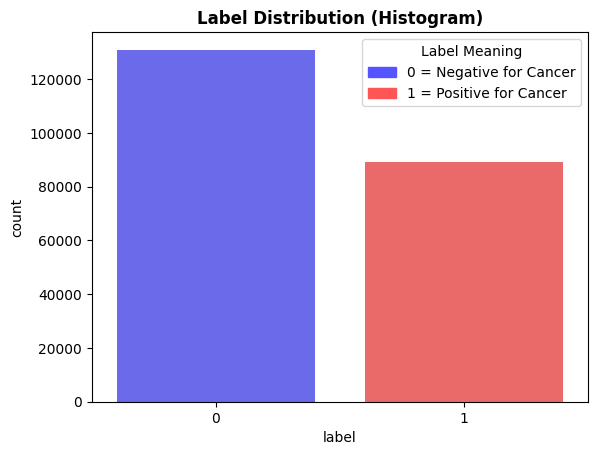

In [11]:
# -----------------------------
# Histogram
# -----------------------------
colors = sns.color_palette("seismic", 2).as_hex()
ax = sns.countplot(
    x=train_raw["label"],
    palette="seismic"
)
ax.set(title="Label Distribution (Histogram)")
ax.title.set_fontweight("bold")

legend_patches = [
    Patch(color=colors[0], label="0 = Negative for Cancer"),
    Patch(color=colors[1], label="1 = Positive for Cancer")
]

plt.legend(handles=legend_patches, title="Label Meaning", loc="upper right")
plt.show()

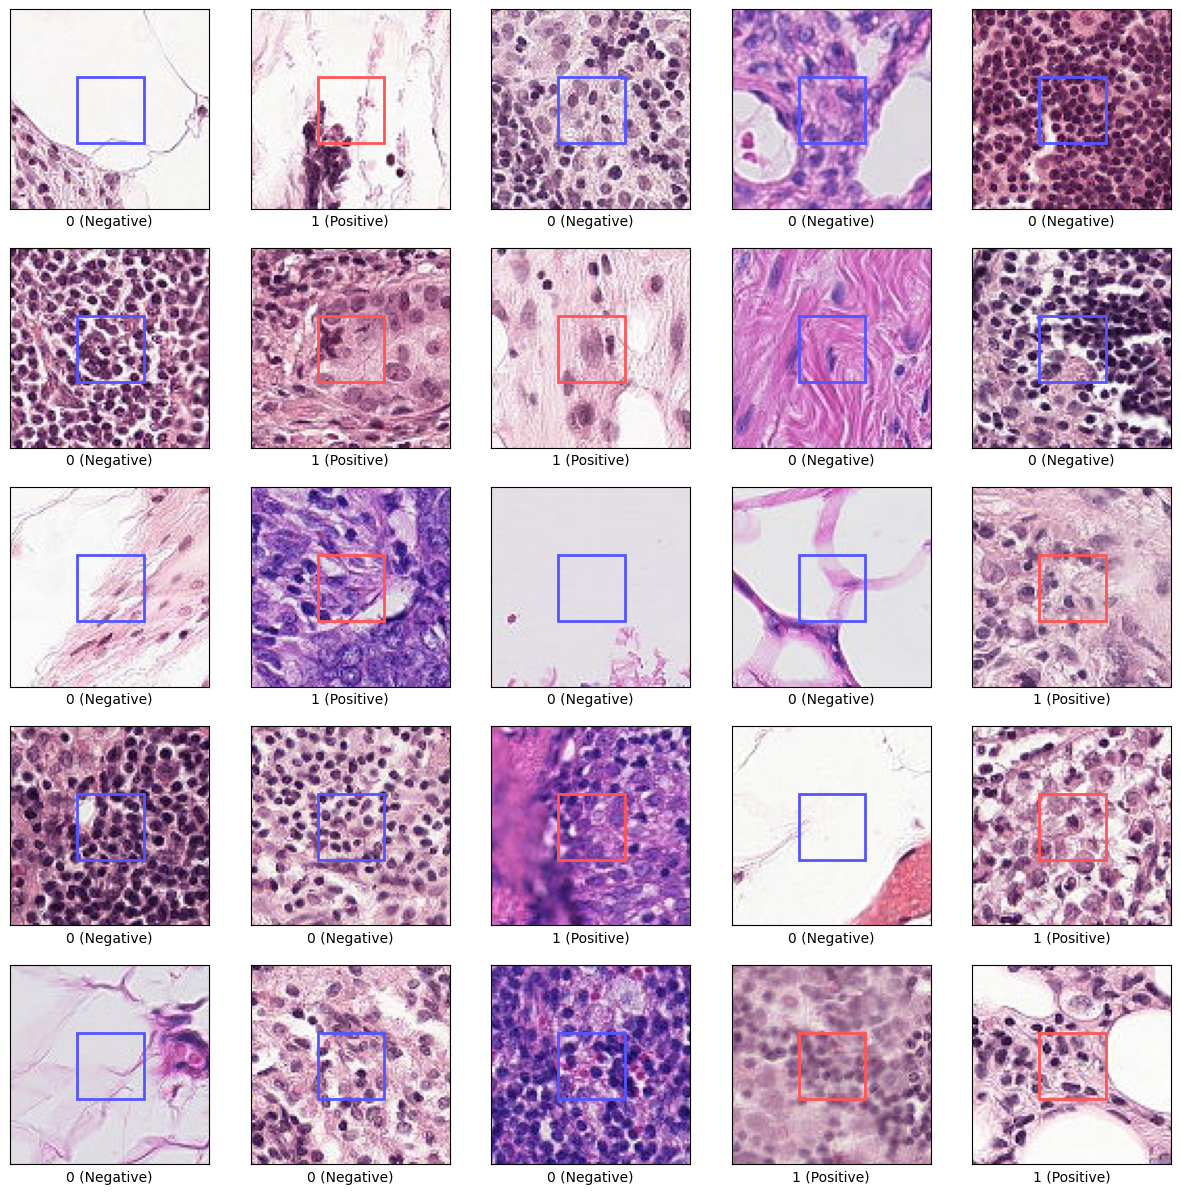

In [12]:
# -----------------------------
# Visualize some images from train_raw
# -----------------------------
label_colors = sns.color_palette("seismic", 2)

fig, ax = plt.subplots(5, 5, figsize=(15, 15))

for i, axis in enumerate(ax.flat):
    file = str(train_path + train_raw.id[i] + ".tif")
    image = io.imread(file)
    axis.imshow(image,
                #cmap="gray"
               )
    label = train_raw.label[i]
    color = label_colors[label]
    box = Rectangle((32, 32), 32, 32,
                     linewidth=2,
                     edgecolor=color,
                     facecolor="none")
    axis.add_patch(box)
    
    # Set label below image
    axis.set(
        xlabel=f"{label} ({'Negative' if label==0 else 'Positive'})",
        xticks=[], yticks=[]
    )

plt.show()

<br>

---
---
# **3. Model Architecture**
---

Before we build our models, we set our initial hyperparameters. Since we were examining a small
$32 \times 32$
region in the middle of the imagee, overall image size was determined to be `img = (96, 96)`. We set `batch_size = 32` to reduce memory usage when training our model.

We set our file paths and train target values, and then we we created a folder to gather all the images for our test set.

From here, we built our helper functions to generate our data for the following subsets:

  * train + valid: both split from or original raw training data
  * test: unlabeled images for us to classify as malignont or non-malignant.

From here, we developed two models:

  * Simple Sequential CNN
  * VGGNet

In [13]:
# -----------------------------
# Inital Hyperparameters
# -----------------------------
img_size = (96, 96)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

In [14]:
# -----------------------------
# File paths
# -----------------------------
train_files = [os.path.join(train_path, f"{fid}.tif") for fid in train_raw.id]
train_targets = train_raw.label.values

# Grab all TIFF files in the folder
test_files = sorted([
    os.path.join(test_path, f) for f in os.listdir(test_path) if f.endswith(".tif")
])

In [15]:
# -----------------------------
# Dataset generator functions
# -----------------------------
def load_img_train(path, label):
    path = path.numpy().decode("utf-8")
    img = io.imread(path)
    # Convert to tensor early to avoid dtype mismatch
    img = tf.convert_to_tensor(img)
    
    if img.ndim == 2:                               # Grayscale
        img = tf.stack([img, img, img], axis=-1)    # Force RGB
    elif img.shape[-1] == 4:                        # RGBA
        img = img[..., :3]

    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label


def set_shape_train(img, label):
    img.set_shape((*img_size, 3))
    label.set_shape(())
    return img, label


def load_img_test(path):
    path = path.numpy().decode("utf-8")
    img = io.imread(path)

    img = tf.convert_to_tensor(img)

    # Grayscale
    if img.ndim == 2:
        img = tf.stack([img, img, img], axis=-1)

    # Weird TIFFs shaped (H, 3)
    if img.ndim == 2 and img.shape[-1] == 3:
        img = tf.expand_dims(img, axis=1)

    # RGBA
    if img.shape[-1] == 4:
        img = img[..., :3]

    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0
    return img


def load_img_test_wrapper(path):
    img = tf.py_function(load_img_test, [path], tf.float32)
    img.set_shape((*img_size, 3))
    return img

In [16]:
# -----------------------------
# Train + Val Set
# -----------------------------
train_raw_data = tf.data.Dataset.from_tensor_slices((train_files, train_targets))
train_raw_data = train_raw_data.map(
    lambda x, y: tf.py_function(load_img_train, [x, y], [tf.float32, tf.int64]),
    num_parallel_calls=AUTOTUNE
)
train_raw_data = train_raw_data.map(set_shape_train)
train_raw_data = train_raw_data.shuffle(1000)

val_split = 0.2
n_val = int(len(train_files) * val_split)

# Final split: Take/skip AFTER batching
val_set   = train_raw_data.take(n_val).batch(batch_size).cache().prefetch(AUTOTUNE)
train_set = train_raw_data.skip(n_val).batch(batch_size).cache().prefetch(AUTOTUNE)

I0000 00:00:1764799647.992855      98 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764799647.993561      98 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [17]:
# -----------------------------
# Test Set
# -----------------------------
test_set = tf.data.Dataset.from_tensor_slices(test_files)
test_set = test_set.map(load_img_test_wrapper, num_parallel_calls=AUTOTUNE)
test_set = test_set.batch(batch_size).prefetch(AUTOTUNE)

---
## Model 1: Sequential CNN

Our first model is simple sequential model with
${\color{ForestGreen}{n}}
    = {\color{ForestGreen}{10}}$
layers, as listed below. The
${\color{CornflowerBlue}{6}}$
trainable layers are marked in CornflowerBlue, and the
${\color{MediumSeaGreen}{4}}$
non-traininable layers are marked in MediumSeaGreen.

> 1. ${\color{CornflowerBlue}{\texttt{Conv2D}}}$
> 2. ${\color{MediumSeaGreen}{\texttt{MaxPooling2D}}}$
> 3. ${\color{CornflowerBlue}{\texttt{BatchNormalization}}}$
> 4. ${\color{CornflowerBlue}{\texttt{Conv2D}}}$
> 5. ${\color{MediumSeaGreen}{\texttt{MaxPooling2D}}}$
> 6. ${\color{CornflowerBlue}{\texttt{BatchNormalization}}}$
> 7. ${\color{MediumSeaGreen}{\texttt{Flatten}}}$
> 8. ${\color{MediumSeaGreen}{\texttt{Dropout}}}$
> 9. ${\color{CornflowerBlue}{\texttt{Dense}}}$
> 10. ${\color{CornflowerBlue}{\texttt{Dense}}}$

Our 2D convolutional layers each have
${\color{ForestGreen}{32}}$
filters, each one being scanned by a
${\color{LightCoral}{3}} \times {\color{LightCoral}{3}}$
kernel.
The number of filters was chosen to avoid using too much memory while training. The kernel size was chosen to ensure we were getting the convolutional value for the pixel in the middle of the kernel as it scanned the whole image. We chose ReLU for the activation function of our hidden layers to address the vanishing gradient problem while training our neural network. We chose sigmoid as the activation function for our output layer because we expected binary output (ie.
${\color{Crimson}{0}}$
for a patient testing positive for cancer and
${\color{RoyalBlue}{1}}$
for a patient whose histopathology scans are negative for cancer.) The output layer only has
${\color{ForestGreen}{1}}$
filter because we exect only one value. We use Adam as our optimizer to enable faster convergence and binary cross-entropy as our loss function because our expected output is binary.

In [20]:
# -----------------------------
# Sequential CNN Model
# -----------------------------
def seq_cnn(dropout_rate=0.2, lr=0.001, input_shape=(*img_size, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),
        
        layers.Conv2D(32, (3,3), activation="relu"),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),
        
        layers.Flatten(),
        layers.Dropout(dropout_rate),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics = ["accuracy", tf.keras.metrics.AUC(name="roc_auc", curve="ROC")]
    )
    return model

---
## Model 2: VGGNet

Our second model expands on our first choice of architecture by adding another
${\color{CornflowerBlue}{\texttt{Conv2D}}}$
layer between what used to just be a sequence of
${\color{CornflowerBlue}{\texttt{Conv2D}}}
    \rightarrow {\color{MediumSeaGreen}{\texttt{MaxPooling2D}}}$.
This seemed like the easiest way to improve model without rebuilding the architecture entirely. Our new model has
${\color{ForestGreen}{n}}
    = {\color{ForestGreen}{12}}$
layers, as listed below. The
${\color{CornflowerBlue}{8}}$
trainable layers are marked in CornflowerBlue, and the
${\color{MediumSeaGreen}{4}}$
non-traininable layers are marked in MediumSeaGreen.

> 1. ${\color{CornflowerBlue}{\texttt{Conv2D}}}$
> 2. ${\color{CornflowerBlue}{\texttt{Conv2D}}}
        \; \rightarrow \;
        \textsf{new layer}$
> 3. ${\color{MediumSeaGreen}{\texttt{MaxPooling2D}}}$
> 4. ${\color{CornflowerBlue}{\texttt{BatchNormalization}}}$
> 5. ${\color{CornflowerBlue}{\texttt{Conv2D}}}$
> 6. ${\color{CornflowerBlue}{\texttt{Conv2D}}}
        \; \rightarrow \;
        \textsf{new layer}$
> 7. ${\color{MediumSeaGreen}{\texttt{MaxPooling2D}}}$
> 8. ${\color{CornflowerBlue}{\texttt{BatchNormalization}}}$
> 9. ${\color{MediumSeaGreen}{\texttt{Flatten}}}$
> 10. ${\color{MediumSeaGreen}{\texttt{Dropout}}}$
> 11. ${\color{CornflowerBlue}{\texttt{Dense}}}$
> 12. ${\color{CornflowerBlue}{\texttt{Dense}}}$

Aside from these changes, our model architecture remains the same.

In [19]:
# -----------------------------
# VGGNet Model
# -----------------------------
def vgg_net(dropout_rate=0.2, lr=0.001, input_shape=(*img_size, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", padding="same",
                      input_shape=input_shape),
        layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),
        
        layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),
        
        layers.Flatten(),
        layers.Dropout(dropout_rate),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics = ["accuracy", tf.keras.metrics.AUC(name="roc_auc", curve="ROC")]
    )
    return model

<br>

---
---
# **4. Results and Analysis**

---
## Model 1: Sequential CNN (Tuning on Train + Valid)

As we ran our model we tuned it to see which parameters would lead to higher accuracy and ROC_AUC curve scores:

* `{"dropout_rate": 0.2, "lr": 0.001}`
* `{"dropout_rate": 0.2, "lr": 0.0005}`

We ran this across
${\color{Sienna}{k}}
    = {\color{Sienna}{10}}$
epochs, but applied `tf.keras.callbacks.EarlyStopping()` to avoid overfitting. For each of our parameters groups, we chose the model iterations that would give us the best ROC_AUC score for our validation set, and plotted them below.

Our train train set is plotted in blue and our validation set is plotted in red. For both parameters groups, our train set had higher accuracy and ROC-AUC than our validation set. Higer scores were found when our learning rate was set to
${\color{HotPink}{\eta}}
    = {\color{HotPink}{0.0005}}$,
showing the lower learning rates leads to improved model performance. We highlighted the values for this best model in plum in our plot below.

<div style = "background-color: GhostWhite;
             padding: 10px;
             border: 4px solid Blue;
             margin-left: 2em;">

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

</div>

In [21]:
# -----------------------------
# Tuning and Metrics
# -----------------------------
hyperparams = [
    {"dropout_rate": 0.2, "lr": 0.001},
    {"dropout_rate": 0.2, "lr": 0.0005},
]

best_val_auc = 0
best_model_seq_cnn = None
seq_cnn_summary = []

def seq_cnn_predict(model, dataset, labeled=True):
    all_probs = []
    all_labels = []
    for batch in tqdm(dataset, desc="Predicting"):
        if labeled:
            imgs, labels = batch
            all_labels.append(labels.numpy())
        else:
            imgs = batch
        probs = model.predict(imgs, verbose=0)
        all_probs.append(probs)
    all_probs = np.concatenate(all_probs, axis=0).flatten()
    if labeled:
        all_labels = np.concatenate(all_labels, axis=0).flatten()
        return all_probs, all_labels
    else:
        return all_probs

for params in hyperparams:
    print(f"\nTraining model with params: {params}")
    model = seq_cnn(**params)
    
    history = model.fit(
        train_set,
        validation_data=val_set,
        epochs=10,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True
        )]
    )
    
    # Predict train + val
    train_probs, train_labels = seq_cnn_predict(model, train_set, labeled=True)
    val_probs, val_labels     = seq_cnn_predict(model, val_set, labeled=True)

    # Convert probabilities to binary predictions
    train_preds = (train_probs > 0.5).astype(int)
    val_preds   = (val_probs > 0.5).astype(int)

    # Compute metrics
    train_auc = roc_auc_score(train_labels, train_probs)
    val_auc   = roc_auc_score(val_labels, val_probs)
    train_acc = accuracy_score(train_labels, train_preds)
    val_acc   = accuracy_score(val_labels, val_preds)

    print(f"Train Acc: {train_acc:.4f} | Train ROC-AUC: {train_auc:.4f}")
    print(f"Val Acc: {val_acc:.4f} | Val   ROC-AUC: {val_auc:.4f}")
    
    # Save metrics for seq_cnn_summary
    seq_cnn_summary.append({
        "dropout_rate": params["dropout_rate"],
        "lr": params["lr"],
        "train_acc": train_acc,
        "train_auc": train_auc,
        "val_acc": val_acc,
        "val_auc": val_auc
    })
    
    # Track best model by val ROC-AUC
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model_seq_cnn = model
        print("Best model updated!")


# -----------------------------
# Metrics summary table
# -----------------------------
seq_cnn_summary = pd.DataFrame(seq_cnn_summary)
print("\nHyperparameter tuning summary:")
print(seq_cnn_summary)


# -----------------------------
# Best model metrics
# -----------------------------
best_row = seq_cnn_summary.loc[seq_cnn_summary["val_auc"].idxmax()]

print("\nBest model metrics (based on val ROC-AUC):")
print(f"Dropout rate: {best_row['dropout_rate']}")
print(f"Learning rate: {best_row['lr']}")
print(f"Train Accuracy: {best_row['train_acc']:.4f}")
print(f"Train ROC-AUC: {best_row['train_auc']:.4f}")
print(f"Val Accuracy:   {best_row['val_acc']:.4f}")
print(f"Val ROC-AUC:   {best_row['val_auc']:.4f}")


Training model with params: {'dropout_rate': 0.2, 'lr': 0.001}
Epoch 1/10


I0000 00:00:1764800642.992756     155 service.cc:148] XLA service 0x7b9e080298f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764800642.993698     155 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764800642.993719     155 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764800643.433909     155 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/5501 ━━━━━━━━━━━━━━━━━━━━ 5:23 59ms/step - accuracy: 0.5955 - loss: 0.7893 - roc_auc: 0.6896     

I0000 00:00:1764800647.011477     155 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 888s 135ms/step - accuracy: 0.8034 - loss: 0.5067 - roc_auc: 0.8643 - val_accuracy: 0.7757 - val_loss: 0.5064 - val_roc_auc: 0.8832
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - accuracy: 0.8602 - loss: 0.3283 - roc_auc: 0.9302 - val_accuracy: 0.8636 - val_loss: 0.3313 - val_roc_auc: 0.9321
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - accuracy: 0.8845 - loss: 0.2789 - roc_auc: 0.9499 - val_accuracy: 0.8419 - val_loss: 0.4036 - val_roc_auc: 0.9238
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - accuracy: 0.8986 - loss: 0.2460 - roc_auc: 0.9613 - val_accuracy: 0.8076 - val_loss: 0.5629 - val_roc_auc: 0.9168
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - accuracy: 0.9104 - loss: 0.2196 - roc_auc: 0.9691 - val_accuracy: 0.8427 - val_loss: 0.4320 - val_roc_auc: 0.9273


Predicting: 100%|██████████| 1376/1376 [01:28<00:00, 15.51it/s]

Train Acc: 0.8767 | Train ROC-AUC: 0.9460
Val Acc: 0.8636 | Val   ROC-AUC: 0.9322
Best model updated!

Training model with params: {'dropout_rate': 0.2, 'lr': 0.0005}
Epoch 1/10


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - accuracy: 0.7953 - loss: 0.4986 - roc_auc: 0.8599 - val_accuracy: 0.8566 - val_loss: 0.3387 - val_roc_auc: 0.9255
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - accuracy: 0.8601 - loss: 0.3286 - roc_auc: 0.9299 - val_accuracy: 0.8488 - val_loss: 0.3738 - val_roc_auc: 0.9232
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - accuracy: 0.8869 - loss: 0.2745 - roc_auc: 0.9516 - val_accuracy: 0.8690 - val_loss: 0.3247 - val_roc_auc: 0.9369
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - accuracy: 0.9062 - loss: 0.2300 - roc_auc: 0.9663 - val_accuracy: 0.8602 - val_loss: 0.3802 - val_roc_auc: 0.9318
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - accuracy: 0.9207 - loss: 0.1943 - roc_auc: 0.9759 - val_accuracy: 0.8656 - val_loss: 0.3936 - val_roc_auc: 0.9309
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - accuracy: 0.9317 - loss: 0.1692 - roc_auc: 0.9816 - val_accuracy: 0.8564 - val_loss: 0.4267 - val_r

Predicting: 100%|██████████| 1376/1376 [01:26<00:00, 15.91it/s]

Train Acc: 0.9060 | Train ROC-AUC: 0.9663
Val Acc: 0.8690 | Val   ROC-AUC: 0.9372
Best model updated!

Hyperparameter tuning summary:
   dropout_rate      lr  train_acc  train_auc   val_acc   val_auc
0           0.2  0.0010   0.876662   0.945971  0.863629  0.932247
1           0.2  0.0005   0.906011   0.966325  0.868992  0.937194

Best model metrics (based on val ROC-AUC):
Dropout rate: 0.2
Learning rate: 0.0005
Train Accuracy: 0.9060
Train ROC-AUC: 0.9663
Val Accuracy:   0.8690
Val ROC-AUC:   0.9372


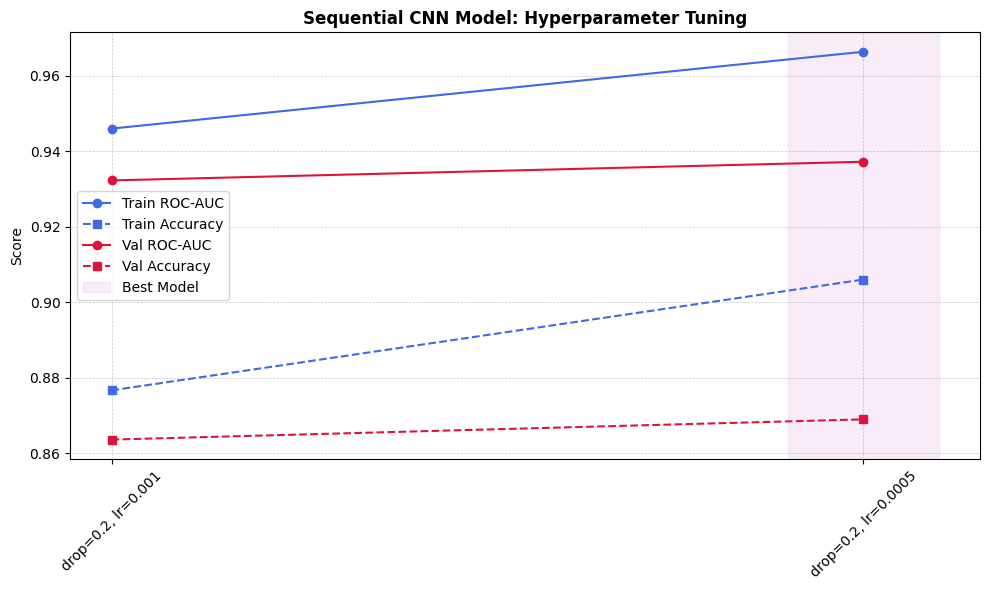

In [26]:
# ------------------------
# Plot Results
# ------------------------
seq_cnn_summary["label"] = seq_cnn_summary.apply(
    lambda row: f"drop={row['dropout_rate']}, lr={row['lr']}", axis=1
)

x = range(len(seq_cnn_summary))
plt.figure(figsize=(10,6))
plt.plot(x, seq_cnn_summary["train_auc"], marker="o", linestyle="-", 
         color="RoyalBlue", label="Train ROC-AUC")
plt.plot(x, seq_cnn_summary["train_acc"], marker="s", linestyle="--", 
         color="RoyalBlue", label="Train Accuracy")

plt.plot(x, seq_cnn_summary["val_auc"], marker="o", linestyle="-",
         color="Crimson", label="Val ROC-AUC")
plt.plot(x, seq_cnn_summary["val_acc"], marker="s", linestyle="--",
         color="Crimson", label="Val Accuracy")

# Highlight best model
highlight_x = len(seq_cnn_summary) - 1
plt.axvspan(
    highlight_x - 0.1,  # left boundary
    highlight_x + 0.1,  # right boundary
    color="Plum",
    alpha=0.2,
    label="Best Model"
)

# Labels & style
plt.xticks(x, seq_cnn_summary["label"], rotation=45)
plt.title("Sequential CNN Model: Hyperparameter Tuning", weight="bold")
plt.ylabel("Score")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# -----------------------------
# Sequential CNN on test set
# -----------------------------
test_probs_seq_cnn = seq_cnn_predict(best_model_seq_cnn, test_set, labeled=False)
test_files_sorted = sorted([f for f in os.listdir(test_path) if f.endswith(".tif")])
test_ids = [os.path.splitext(f)[0] for f in test_files_sorted]

submission_seq_cnn = pd.DataFrame({
    "id": test_ids,
    "label": test_probs_seq_cnn
})
submission_seq_cnn.to_csv("submission_seq_cnn.csv", index=False)
print("Submission CSV saved for Sequential CNN model.")

Predicting: 100%|██████████| 1796/1796 [03:39<00:00,  8.19it/s]


Submission CSV saved for Sequential CNN model.


---
## Model 2: VGGNet (Tuning on Train + Valid)

Again, we tuned our VGGNet model by checking the same parameter groups we used on the simple sequential CNN model. Surprisingly, this model actually had higher accuracy and ROC-AUC scores where the learning rate was set to
${\color{HotPink}{\eta}}
    = {\color{HotPink}{0.0001}}$,
suggesting the model may be overfitting at the decreased learning rate that gave the previous model better performance. However, scores for the VGGNet model were still higher overall than than ones obtained from the simple sequential CNN model.

In [25]:
# -----------------------------
# Tuning and Metrics
# -----------------------------
hyperparams = [
    {"dropout_rate": 0.2, "lr": 0.001},
    {"dropout_rate": 0.2, "lr": 0.0005},
]

best_val_auc = 0
best_model_vgg = None
vgg_summary = []

def vgg_net_predict(model, dataset, labeled=True):
    all_probs = []
    all_labels = []
    for batch in tqdm(dataset, desc="Predicting"):
        if labeled:
            imgs, labels = batch
            all_labels.append(labels.numpy())
        else:
            imgs = batch
        probs = model.predict(imgs, verbose=0)
        all_probs.append(probs)
    all_probs = np.concatenate(all_probs, axis=0).flatten()
    if labeled:
        all_labels = np.concatenate(all_labels, axis=0).flatten()
        return all_probs, all_labels
    else:
        return all_probs

for params in hyperparams:
    print(f"\nTraining model with params: {params}")
    model = vgg_net(**params)
    
    history = model.fit(
        train_set,
        validation_data=val_set,
        epochs=10,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True
        )]
    )
    
    # Predict train + val
    train_probs, train_labels = vgg_net_predict(model, train_set, labeled=True)
    val_probs, val_labels     = vgg_net_predict(model, val_set, labeled=True)

    # Convert probabilities to binary predictions
    train_preds = (train_probs > 0.5).astype(int)
    val_preds   = (val_probs > 0.5).astype(int)

    # Compute metrics
    train_auc = roc_auc_score(train_labels, train_probs)
    val_auc   = roc_auc_score(val_labels, val_probs)
    train_acc = accuracy_score(train_labels, train_preds)
    val_acc   = accuracy_score(val_labels, val_preds)

    print(f"Train Acc: {train_acc:.4f} | Train ROC-AUC: {train_auc:.4f}")
    print(f"Val Acc:   {val_acc:.4f}   | Val   ROC-AUC: {val_auc:.4f}")
    
    # Save metrics for vgg_summary
    vgg_summary.append({
        "dropout_rate": params["dropout_rate"],
        "lr": params["lr"],
        "train_acc": train_acc,
        "train_auc": train_auc,
        "val_acc": val_acc,
        "val_auc": val_auc
    })
    
    # Track best model by val ROC-AUC
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model_vgg = model
        print("Best model updated!")
        

# -----------------------------
# Metrics summary table
# -----------------------------
vgg_summary = pd.DataFrame(vgg_summary)
print("\nHyperparameter tuning vgg_summary:")
print(vgg_summary)


# -----------------------------
# Best model metrics
# -----------------------------
best_row = vgg_summary.loc[vgg_summary["val_auc"].idxmax()]

print("\nBest model metrics (based on val ROC-AUC):")
print(f"Dropout rate: {best_row['dropout_rate']}")
print(f"Learning rate: {best_row['lr']}")
print(f"Train Accuracy: {best_row['train_acc']:.4f}")
print(f"Train ROC-AUC: {best_row['train_auc']:.4f}")
print(f"Val Accuracy:   {best_row['val_acc']:.4f}")
print(f"Val ROC-AUC:   {best_row['val_auc']:.4f}")


Training model with params: {'dropout_rate': 0.2, 'lr': 0.001}
Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 100s 17ms/step - accuracy: 0.8144 - loss: 0.4221 - roc_auc: 0.8851 - val_accuracy: 0.8502 - val_loss: 0.3844 - val_roc_auc: 0.9154
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 93s 17ms/step - accuracy: 0.8834 - loss: 0.2826 - roc_auc: 0.9476 - val_accuracy: 0.8883 - val_loss: 0.2814 - val_roc_auc: 0.9515
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 93s 17ms/step - accuracy: 0.9044 - loss: 0.2382 - roc_auc: 0.9627 - val_accuracy: 0.8256 - val_loss: 0.5012 - val_roc_auc: 0.8799
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 93s 17ms/step - accuracy: 0.9161 - loss: 0.2097 - roc_auc: 0.9711 - val_accuracy: 0.8876 - val_loss: 0.3057 - val_roc_auc: 0.9555
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 94s 17ms/step - accuracy: 0.9253 - loss: 0.1872 - roc_auc: 0.9769 - val_accuracy: 0.8918 - val_loss: 0.3146 - val_roc_auc: 0.9444


Predicting: 100%|██████████| 1376/1376 [01:35<00:00, 14.46it/s]

Train Acc: 0.8987 | Train ROC-AUC: 0.9609
Val Acc:   0.8883   | Val   ROC-AUC: 0.9516
Best model updated!

Training model with params: {'dropout_rate': 0.2, 'lr': 0.0005}
Epoch 1/10


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 99s 17ms/step - accuracy: 0.8253 - loss: 0.3999 - roc_auc: 0.8941 - val_accuracy: 0.7980 - val_loss: 0.5128 - val_roc_auc: 0.9036
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 94s 17ms/step - accuracy: 0.8874 - loss: 0.2723 - roc_auc: 0.9519 - val_accuracy: 0.8785 - val_loss: 0.3205 - val_roc_auc: 0.9466
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 94s 17ms/step - accuracy: 0.9139 - loss: 0.2170 - roc_auc: 0.9693 - val_accuracy: 0.7580 - val_loss: 1.9040 - val_roc_auc: 0.7401
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 94s 17ms/step - accuracy: 0.9286 - loss: 0.1804 - roc_auc: 0.9787 - val_accuracy: 0.7632 - val_loss: 1.5210 - val_roc_auc: 0.7669
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 94s 17ms/step - accuracy: 0.9391 - loss: 0.1546 - roc_auc: 0.9842 - val_accuracy: 0.7524 - val_loss: 1.7796 - val_roc_auc: 0.7448


Predicting: 100%|██████████| 1376/1376 [01:36<00:00, 14.28it/s]

Train Acc: 0.8873 | Train ROC-AUC: 0.9598
Val Acc:   0.8785   | Val   ROC-AUC: 0.9469

Hyperparameter tuning vgg_summary:
   dropout_rate      lr  train_acc  train_auc   val_acc   val_auc
0           0.2  0.0010   0.898733   0.960910  0.888308  0.951649
1           0.2  0.0005   0.887274   0.959844  0.878514  0.946907

Best model metrics (based on val ROC-AUC):
Dropout rate: 0.2
Learning rate: 0.001
Train Accuracy: 0.8987
Train ROC-AUC: 0.9609
Val Accuracy:   0.8883
Val ROC-AUC:   0.9516


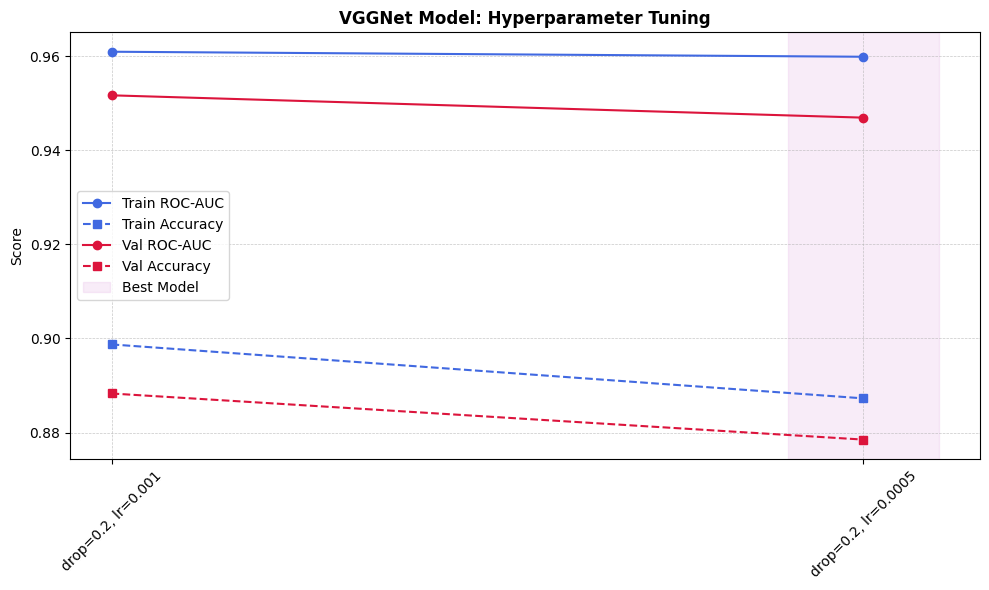

In [27]:
# ------------------------
# Plot Results
# ------------------------
vgg_summary["label"] = vgg_summary.apply(
    lambda row: f"drop={row['dropout_rate']}, lr={row['lr']}", axis=1
)

x = range(len(vgg_summary))
plt.figure(figsize=(10,6))
plt.plot(x, vgg_summary["train_auc"], marker="o", linestyle="-",
         color="RoyalBlue", label="Train ROC-AUC")
plt.plot(x, vgg_summary["train_acc"], marker="s", linestyle="--",
         color="RoyalBlue", label="Train Accuracy")

plt.plot(x, vgg_summary["val_auc"], marker="o", linestyle="-",
         color="Crimson", label="Val ROC-AUC")
plt.plot(x, vgg_summary["val_acc"], marker="s", linestyle="--",
         color="Crimson", label="Val Accuracy")

# Highlight best model
highlight_x = len(vgg_summary) - 1
plt.axvspan(
    highlight_x - 0.1,  # left boundary
    highlight_x + 0.1,  # right boundary
    color="Plum",
    alpha=0.2,
    label="Best Model"
)

# Labels & style
plt.xticks(x, vgg_summary["label"], rotation=45)
plt.title("VGGNet Model: Hyperparameter Tuning", weight="bold")
plt.ylabel("Score")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
# -----------------------------
# VGGNet on test set
# -----------------------------
test_probs_vgg = vgg_net_predict(best_model_vgg, test_set, labeled=False)
test_files_sorted = sorted([f for f in os.listdir(test_path) if f.endswith(".tif")])
test_ids = [os.path.splitext(f)[0] for f in test_files_sorted]

submission_vgg = pd.DataFrame({
    "id": test_ids,
    "label": test_probs_vgg
})
submission_vgg.to_csv("submission_vgg.csv", index=False)
print("CSV saved for VGGNet model.")

Predicting: 100%|██████████| 1796/1796 [03:18<00:00,  9.06it/s]


CSV saved for VGGNet model.


<br>

---
---
# **5. Conclusion**

---
## Final Results


The final accuracy and ROC-AUC scores for all our models are shown in the table below.

| **Seq CNN** | **Params**             | **Train Acc** | **Train ROC-AUC** | **Val Acc** | **Val ROC-AUC**   |
|:-----------:|:----------------------:|:-------------:|:-----------------:|:-----------:|:-------------------:|
|   | `drop = 0.2`, <br> `lr = 0.001`  | $0.876662$    | $0.945971$        | $0.863629$  | $0.932247$          |
|   | `drop = 0.2`, <br> `lr = 0.0005` | $0.906011$    | $0.966325$        | $0.868992$  | $0.937194$          |

<br>

| **VGG Net** | **Params**             | **Train Acc** | **Train ROC-AUC** | **Val Acc** | **Val ROC-AUC**   |
|:-----------:|:----------------------:|:-------------:|:-----------------:|:-----------:|:-------------------:|
|   | `drop = 0.2`, <br> `lr = 0.001`  | $0.898733$    | $0.960910$        | $0.888308$  | $0.951649$ |
|   | `drop = 0.2`, <br> `lr = 0.0005` | $0.887274$    | $0.959844$        | $0.878514$  | $0.946907$ |

As you can see, the VGGNet model almost consistently had higher accuracy and ROC-AUC scores than the simple sequential CNN model for both the train and valid sets. The best performing model was VGGNet with the parameters `drop = 0.2, lr = 0.001`. This gave us ROC-AUC scores of
$0.96$ and $0.95$
for the train and validation sets respectively, suggesting a strong ability to distinguish between positive and negative cancer cases. Additionally, our accuracy scores were at
$\approx 0.90$  and $0.89$
for for the train and validation sets respetively, suggesting high accuracy for detecting cancer.

---
## Discussion

Overall, the VGGNet model performed better than the simple sequential CNN model, likely due to the performance boost from additional stacked convolution layers. Adding more convolution layers to make our VGGNet deeper may have improved performance. Surprisingly, ROC-AUC and accuracy scores both dipped slightly when we lowered the learning rate of this model to `lr = 0.0005`. While reducing the learning rate improved these scores for the simple sequential model, the additional layers in VGGNet may have led the model to overfit, so we didn't get the score boost we saw in the original model.